In [1]:
# Methods found in the following modules are needed for a successful run of Salphagome.

import glob
import pandas as pd
import re
from Bio import Entrez
import time
import xml.etree.ElementTree as ET
import seaborn as sns; sns.set()
import copy
import numpy as np
import subprocess
from Bio import SeqIO

In [2]:
# Edit the locations below to the location of your results folders.

files_control = glob.glob('typhi_results/*species.txt')
files_disease1 = glob.glob('ptyphia_results/*species.txt')
files_disease2 = glob.glob('ptyphib_results/*species.txt')
files_disease3 = glob.glob('ptyphic_results/*species.txt')

location_of_fasta = 'databases/just_viruses/just_viruses.fasta'

In [3]:
#List of sequences in the reference FASTA
fasta_ids = []

with open(location_of_fasta, "r") as handle:
    for record in SeqIO.parse(handle, "fasta") :
        fasta_ids.append(record.id)

print("Total Phages: " + str(len(fasta_ids)))

Total Phages: 153


In [4]:
# Make Master List
master_list = []

#Get read hit counts from control folder

for file in files_control:
    
    name = str(file)
    
    list_of_seqs = copy.deepcopy(fasta_ids)
    
    with open(file, "r") as ifile:
        for line in ifile:
            
            data = line.strip().split(' ')
            data = data+[name, 'typhi']
            master_list.append(data)
            
    for seq in list_of_seqs:
        
        data = [0, seq, name, 'typhi']
        
        master_list.append(data)

In [5]:
#Get read hit counts from disease folder

for file in files_disease1:
    
    list_of_seqs = copy.deepcopy(fasta_ids)
    
    name = str(file)
    
    with open(file, "r") as ifile:
        
        for line in ifile:
            
            data = line.strip().split(' ')
            data = data+[name, 'ptyphia']
            
            list_of_seqs.remove(data[1])
            
            
            master_list.append(data)

    for seq in list_of_seqs:
        
        data = [0, seq, name, 'ptyphia']
        
        master_list.append(data)

In [6]:
#Get read hit counts from disease folder

for file in files_disease2:
    
    list_of_seqs = copy.deepcopy(fasta_ids)
    
    name = str(file)
    
    with open(file, "r") as ifile:
        
        for line in ifile:
            
            data = line.strip().split(' ')
            data = data+[name, 'ptyphib']
            
            list_of_seqs.remove(data[1])
            
            
            master_list.append(data)

    for seq in list_of_seqs:
        
        data = [0, seq, name, 'ptyphib']
        
        master_list.append(data)

In [7]:
#Get read hit counts from disease folder

for file in files_disease3:
    
    list_of_seqs = copy.deepcopy(fasta_ids)
    
    name = str(file)
    
    with open(file, "r") as ifile:
        
        for line in ifile:
            
            data = line.strip().split(' ')
            data = data+[name, 'ptyphic']
            
            list_of_seqs.remove(data[1])
            
            
            master_list.append(data)

    for seq in list_of_seqs:
        
        data = [0, seq, name, 'ptyphic']
        
        master_list.append(data)

In [8]:
# Name items in our current dataframe.

df = pd.DataFrame(columns=['count', 'seq', 'file', 'type'], data= master_list)

In [9]:
# Function to get accession Ids from the SRA.

def get_srr_accession(df):
    """
    Extract the SRR number from the file_location field of the dataframe.
    """
    pattern = re.compile(r"[SED]RR[0-9]+")

    file = df['file']

    return re.search(pattern, file).group(0)

In [10]:
# Include accession Ids in our dataframe.

df['acc'] = df.apply(get_srr_accession, axis=1)

In [11]:
# Convert the counts to integer object.

df['count'] = df['count'].astype(int)

In [12]:
# Function to get the spot counts and use for normalization of the data.

def get_spot_count(df, email, max_errors):
    """
    Use the Entrez API to get the spot (read) count for that SRR number.
    """

    srr_acc = df['acc']
    
    # get SRR id
    Entrez.email = email

    error_count =0

    while error_count < max_errors:

        try:

            handle = Entrez.esearch(db="sra",term=srr_acc)

            record = Entrez.read(handle)

            handle.close()

            srr_id = record["IdList"][0]

            break

        except:

            print ('error occured collecting ID ', srr_acc, error_count)

            time.sleep(10)

            error_count = error_count +1


    # get SRR summary

    error_count =0

    while error_count < max_errors:

        try:

            handle = Entrez.esummary(db='sra', id=srr_id)

            record = Entrez.read(handle)

            handle.close()

            my_xml = record[0]['Runs']

            # Parse XML
            xml_object = ET.fromstringlist(["<root>", my_xml, "</root>"])

            # Get total_spots (reads)
            for child in xml_object:

                if child.attrib['acc'] == srr_acc:

                    #print (srr_acc, child.attrib['total_spots'])

                    return int(child.attrib['total_spots'])

        except:

            print ('error occured collecting spot count', srr_acc, error_count)

            time.sleep(10)

            error_count = error_count +1

In [13]:
data2 = my_list = list(df['acc'].unique())

spot_df = pd.DataFrame(data2, columns=['acc'])

In [14]:
spot_df['spot_count'] = spot_df.apply(get_spot_count, axis=1, args=['visiting.bioinformaticians@gmail.com', 3])
print(spot_df.drop_duplicates(subset=['acc'], keep='last'))

          acc  spot_count
0   DRR071002      668472
1   DRR071001      789639
2   DRR071000     1137918
3   DRR071003      566361
4  ERR2011049      702860
5  ERR2011050      529341
6  ERR2210492      941185


In [15]:
spot_df.to_csv('spot_map.csv')

In [16]:
read_count_dict ={}

for row in spot_df.iterrows():
    read_count_dict[(row[1]['acc'])] = row[1]['spot_count']

In [17]:
def normalise(df):
    
    srr = df['acc']
    
    read_count = read_count_dict[srr]
    
    return read_count

In [18]:
df['read_count'] = df.apply(normalise, axis=1)

In [19]:
df.head()

,count,seq,file,type,acc,read_count
0,11320,NC_010463.1,typhi_results/typhi_phages.DRR071002.sam.speci...,typhi,DRR071002,668472
1,6915,NC_019488.1,typhi_results/typhi_phages.DRR071002.sam.speci...,typhi,DRR071002,668472
2,4298,NC_028699.1,typhi_results/typhi_phages.DRR071002.sam.speci...,typhi,DRR071002,668472
3,3925,NC_010393.1,typhi_results/typhi_phages.DRR071002.sam.speci...,typhi,DRR071002,668472
4,931,NC_019545.1,typhi_results/typhi_phages.DRR071002.sam.speci...,typhi,DRR071002,668472


In [20]:
def normalise_values(df):
    
    return (df['count'] / df['read_count']) * 1000000

In [21]:
df['normalised_count'] = df.apply(normalise_values, axis=1)

In [22]:
df.to_csv('typhi.ptyphi.comparison.csv')

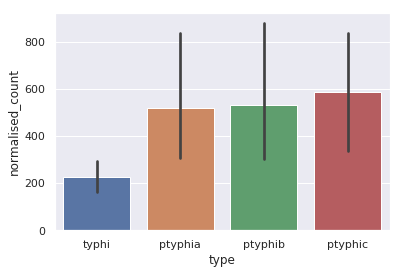

In [23]:
sns.barplot(x='type', y='normalised_count', data=df)

In [24]:
grouped = df.groupby(['type', 'seq']).mean()

In [25]:
grouped['type2'] = grouped.index.levels[0][ grouped.index.labels[0]]

In [26]:
pivoted = grouped.pivot_table(index='seq', values='normalised_count', columns='type2')

In [27]:
def percent_diffa(df):
    
    value1 = df['typhi']
    value2 = df['ptyphia']
    
    pctdiff = abs(value2-value1)/((value1+value2)/2)*100
    
    return pctdiff

def percent_diffb(df):
    
    value1 = df['typhi']
    value2 = df['ptyphib']
    
    pctdiff = abs(value2-value1)/((value1+value2)/2)*100
    
    return pctdiff

def percent_diffc(df):
    
    value1 = df['typhi']
    value2 = df['ptyphic']
    
    pctdiff = abs(value2-value1)/((value1+value2)/2)*100
    
    return pctdiff

In [28]:
pivoted['pct_diffa'] = pivoted.apply(percent_diffa,axis=1)
pivoted['pct_diffb'] = pivoted.apply(percent_diffb,axis=1)
pivoted['pct_diffc'] = pivoted.apply(percent_diffc,axis=1)

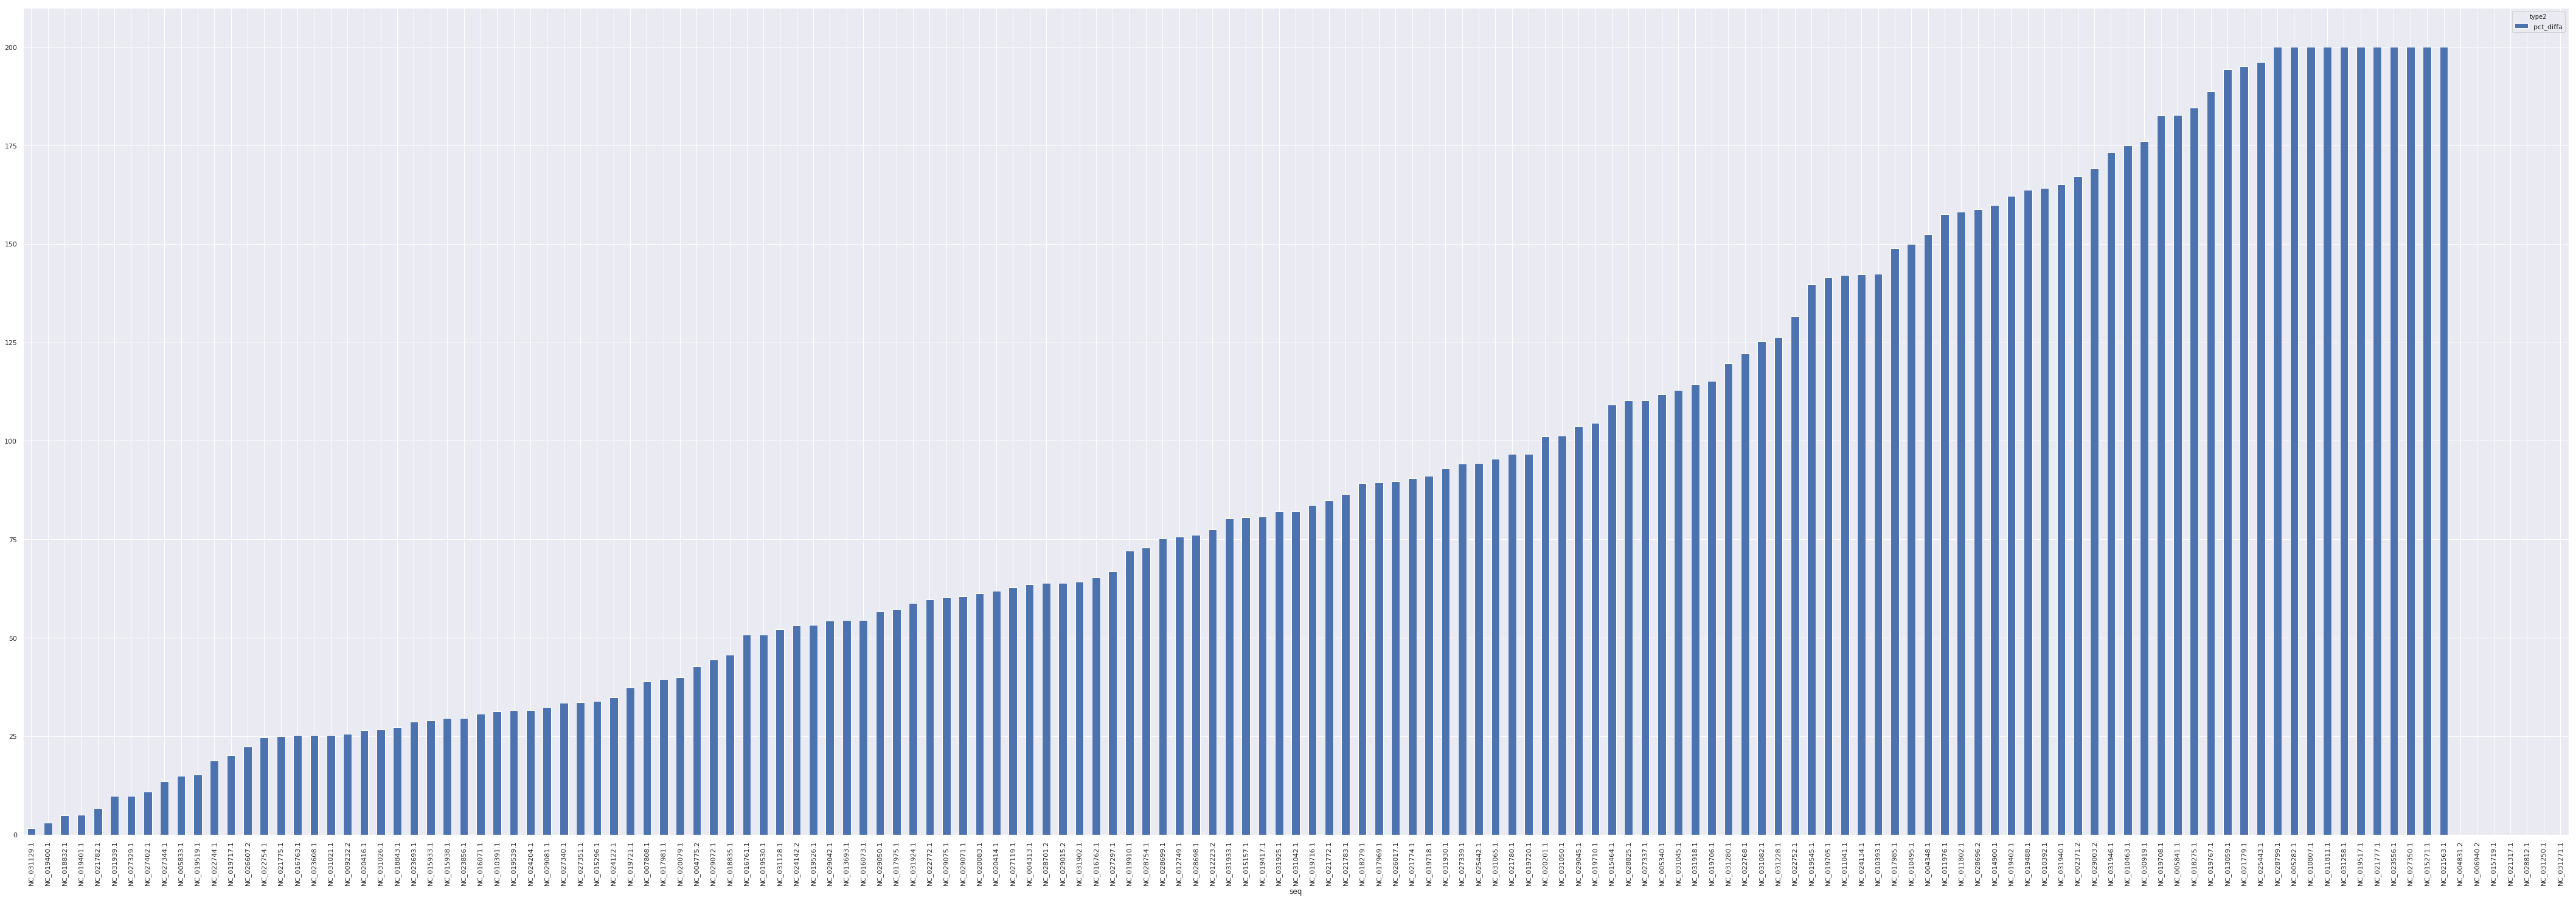

In [29]:
pivoted = pivoted.sort_values('pct_diffa')

pivoted[['pct_diffa']].plot(kind='bar', figsize =(75,25))

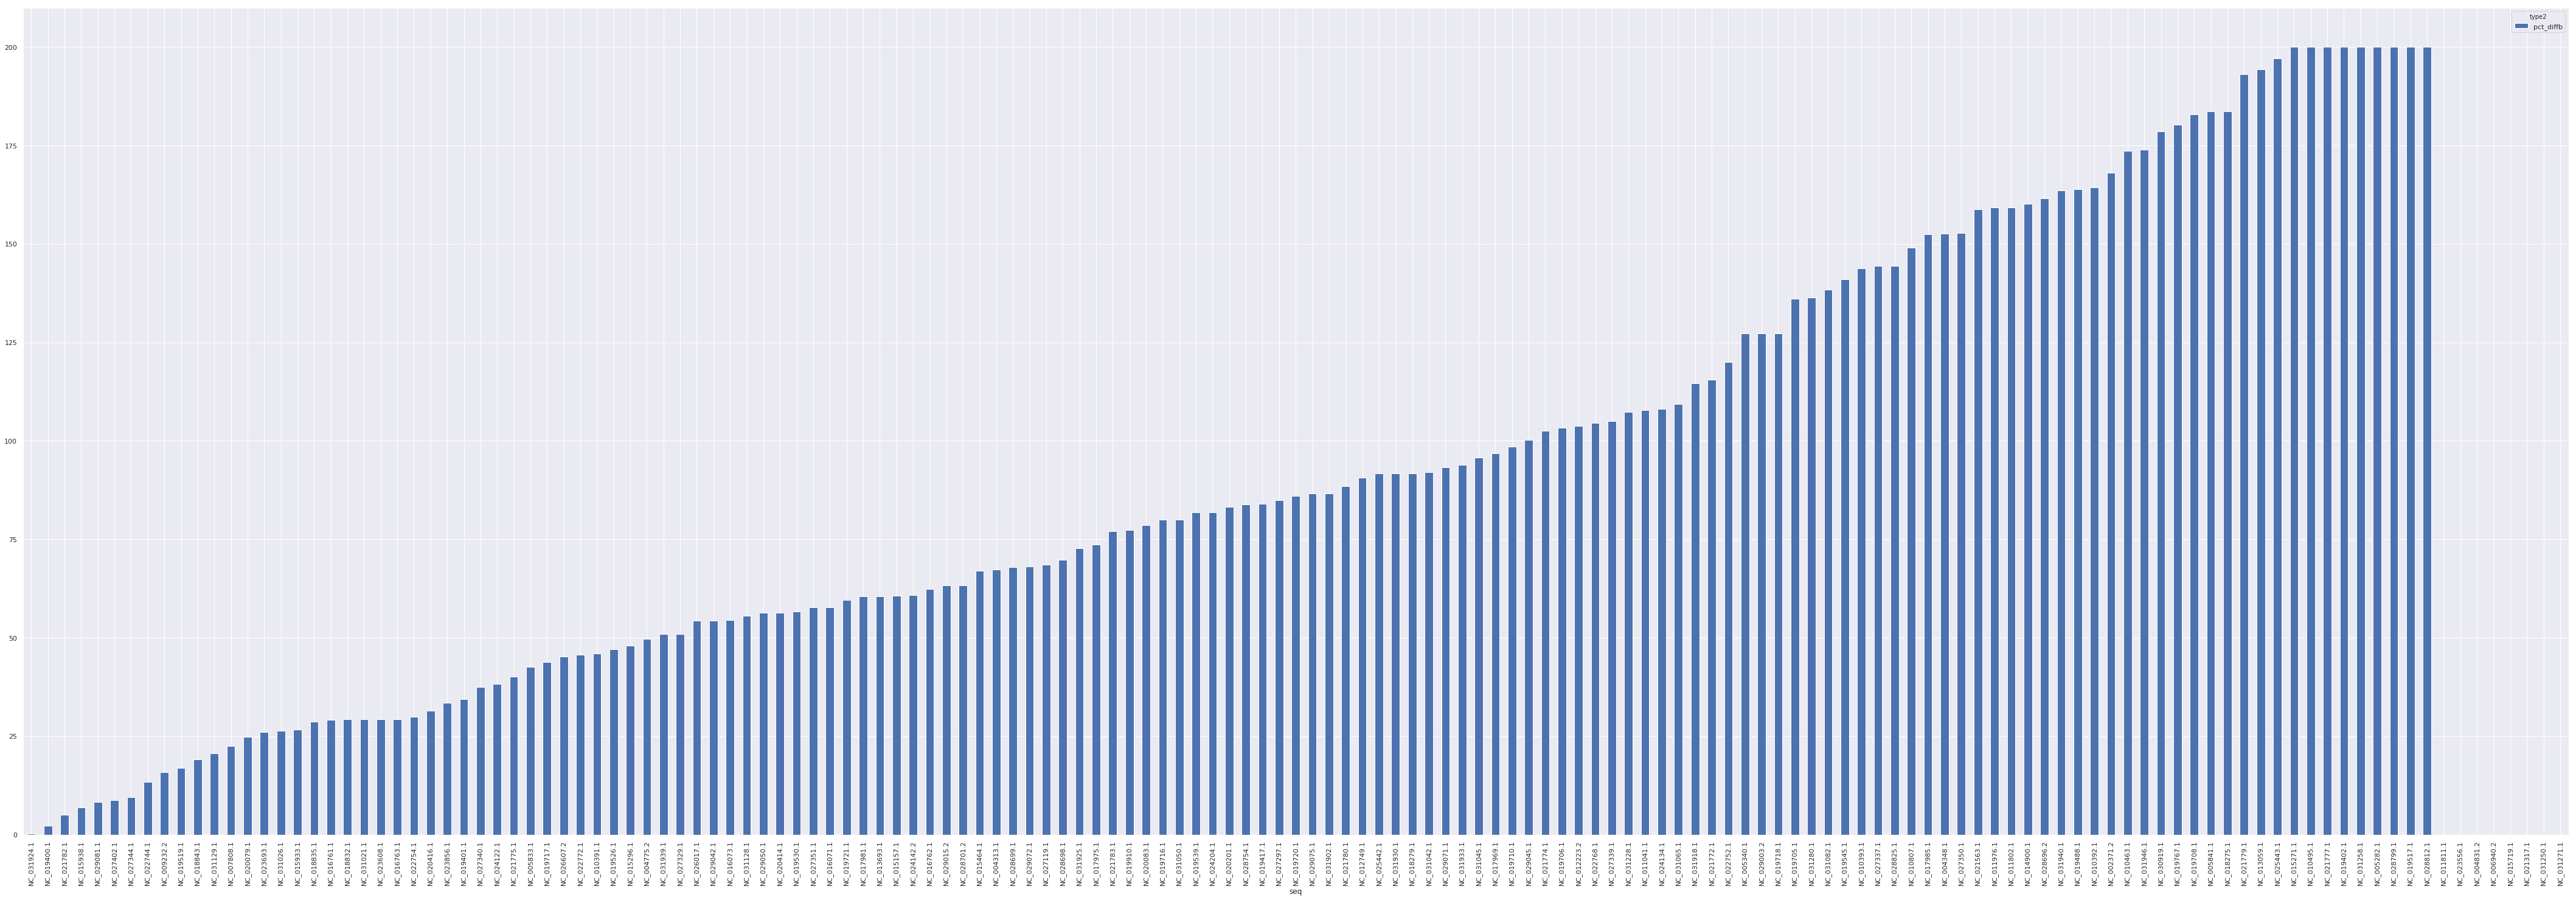

In [30]:
pivoted = pivoted.sort_values('pct_diffb')

pivoted[['pct_diffb']].plot(kind='bar', figsize =(75,25))

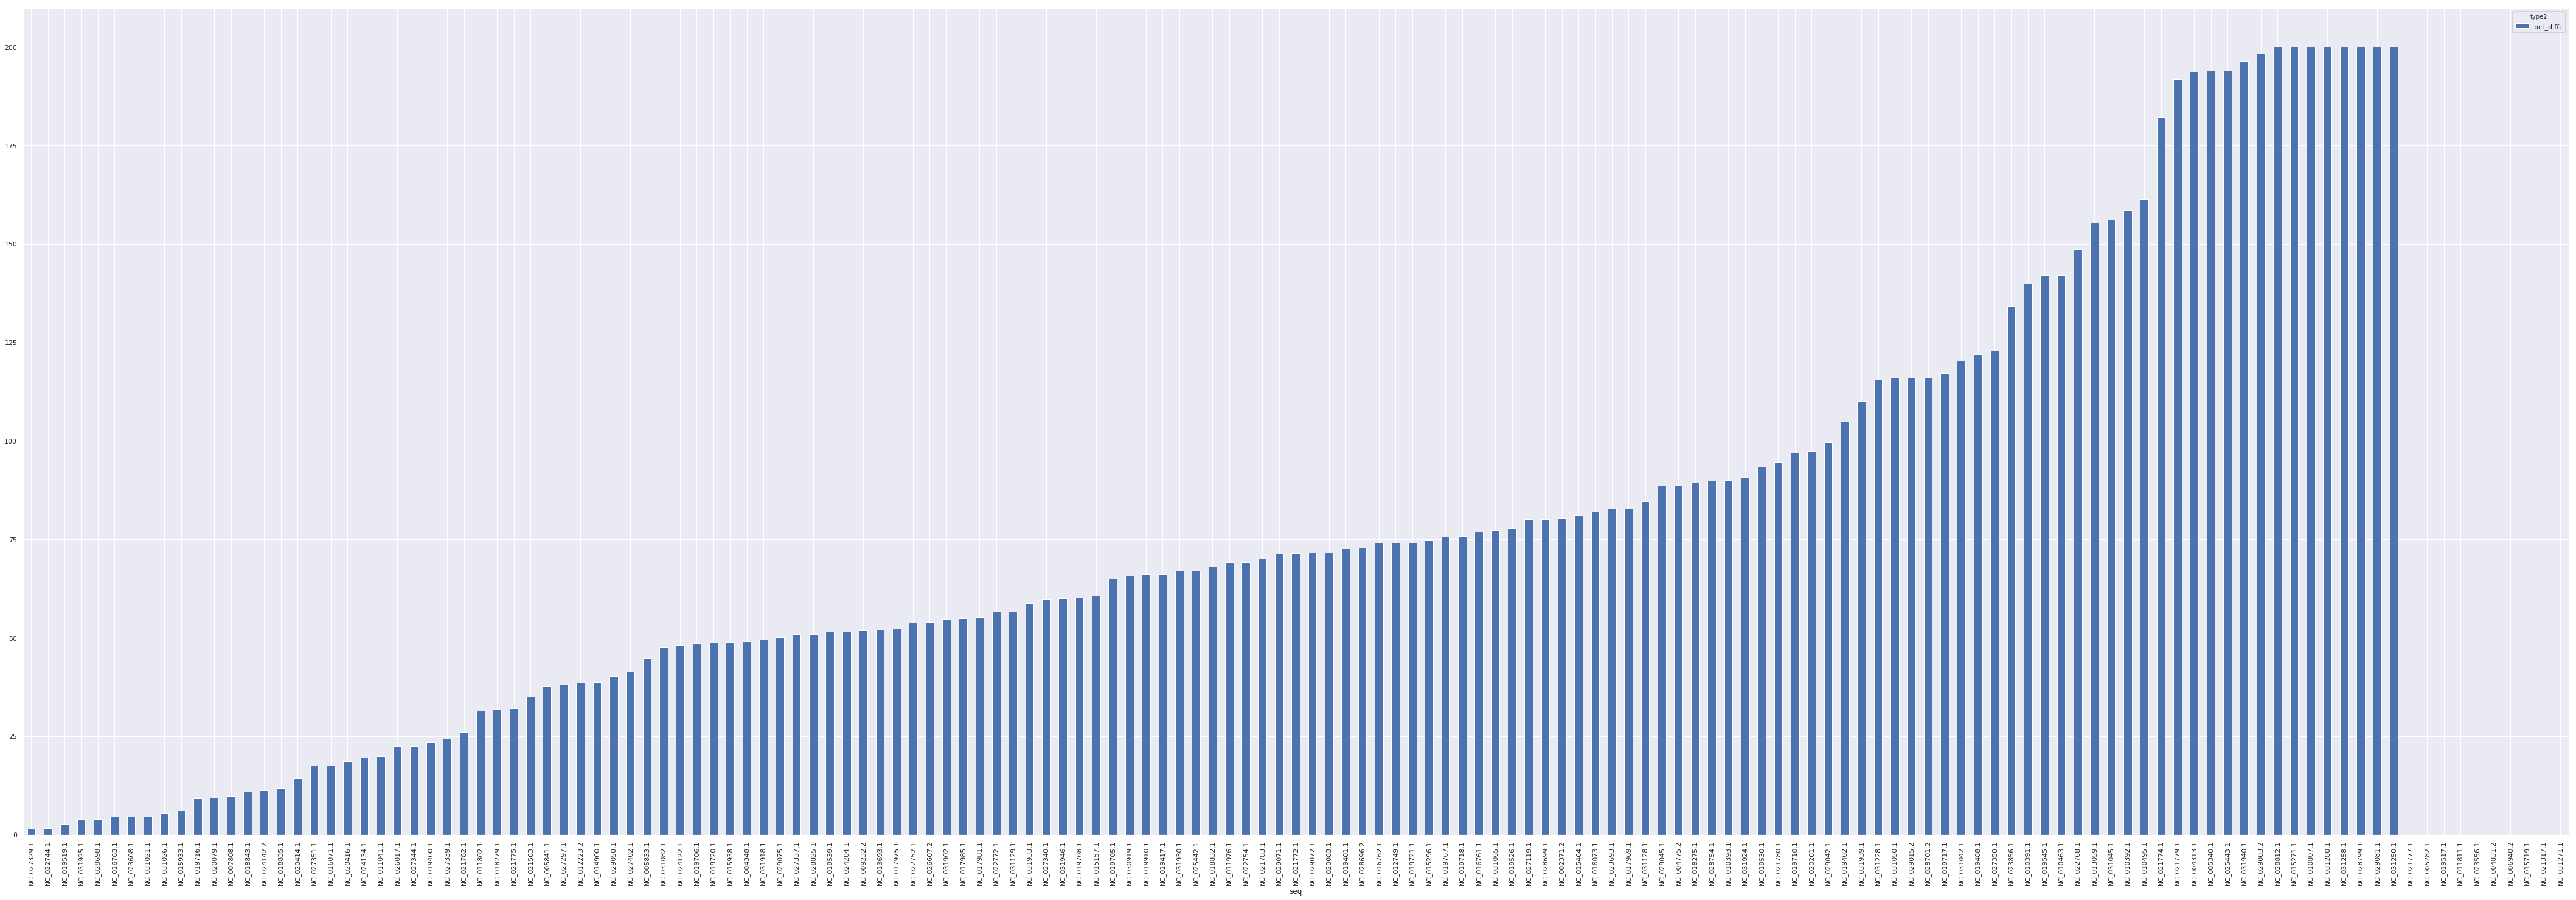

In [31]:
pivoted = pivoted.sort_values('pct_diffc')

pivoted[['pct_diffc']].plot(kind='bar', figsize =(75,25))

In [32]:
def pct_changea(df):
    
    value1 = df['typhi']
    value2 = df['ptyphia']
    
    return ((value1-value2) / value2)*100

def pct_changeb(df):
    
    value1 = df['typhi']
    value2 = df['ptyphib']
    
    return ((value1-value2) / value2)*100

def pct_changec(df):
    
    value1 = df['typhi']
    value2 = df['ptyphic']
    
    return ((value1-value2) / value2)*100

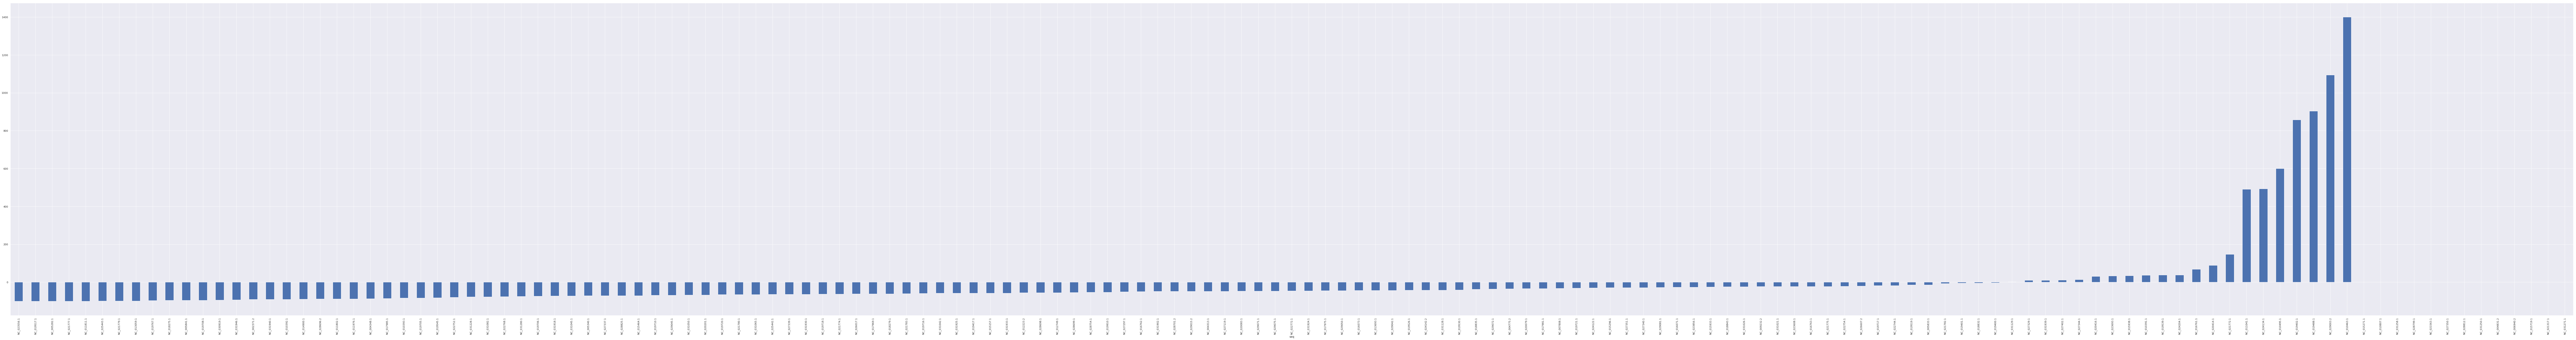

In [33]:
pivoted['pct_changea'] = pivoted.apply(pct_changea, axis=1)
pivoted = pivoted.sort_values('pct_changea')
pivoted['pct_changea'].plot(kind='bar', figsize =(200,25))

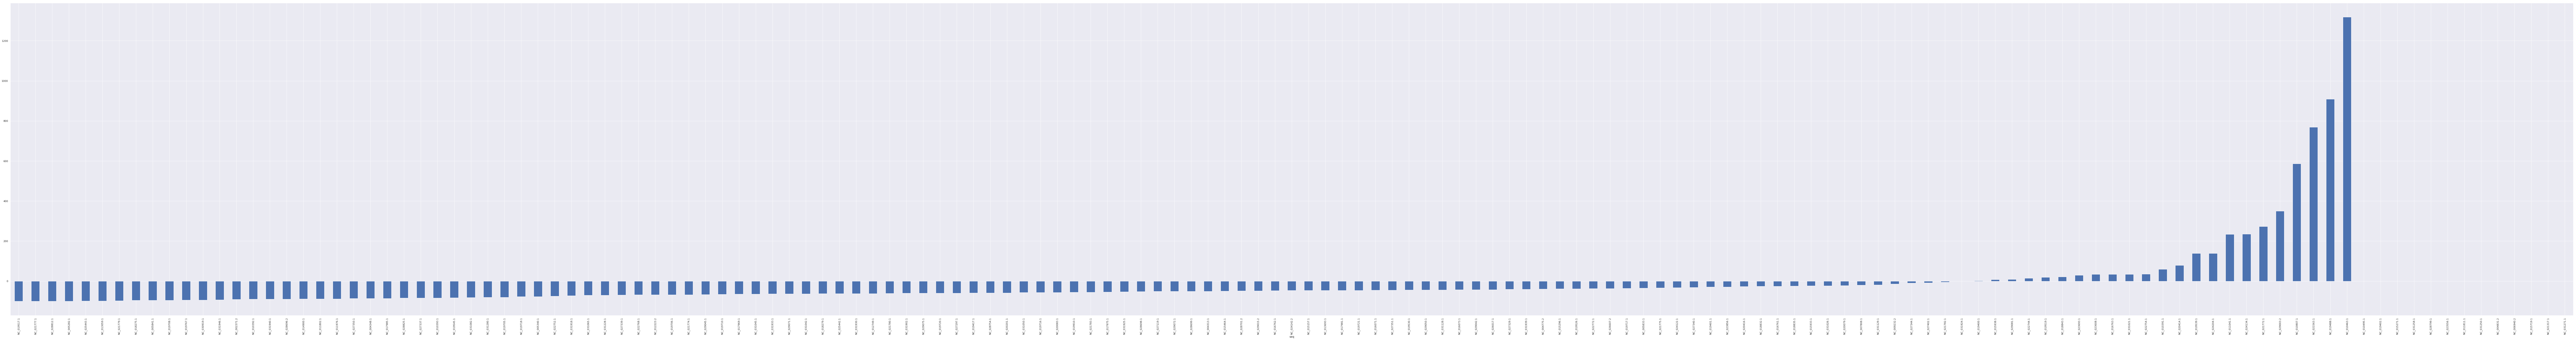

In [34]:
pivoted['pct_changeb'] = pivoted.apply(pct_changeb, axis=1)
pivoted = pivoted.sort_values('pct_changeb')
pivoted['pct_changeb'].plot(kind='bar', figsize =(200,25))

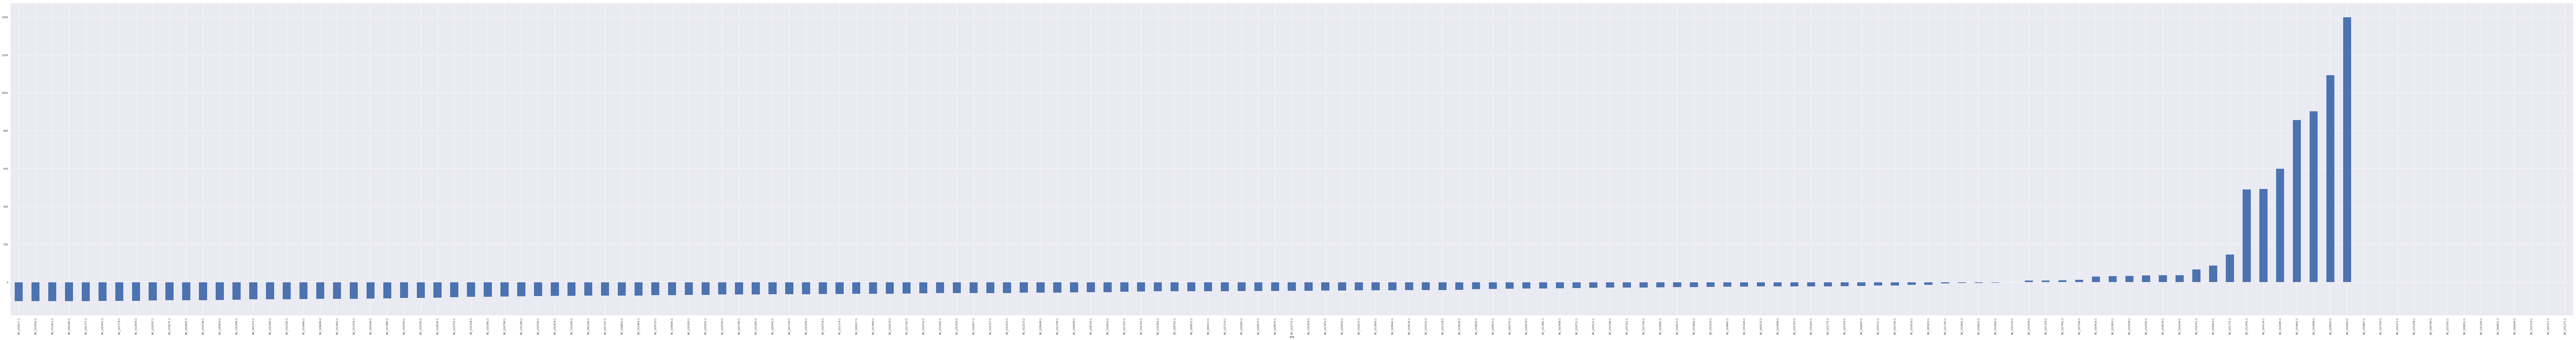

In [35]:
pivoted['pct_changec'] = pivoted.apply(pct_changea, axis=1)
pivoted = pivoted.sort_values('pct_changec')
pivoted['pct_changec'].plot(kind='bar', figsize =(200,25))

In [36]:
pivoted

type2,ptyphia,ptyphib,ptyphic,typhi,pct_diffa,pct_diffb,pct_diffc,pct_changea,pct_changeb,pct_changec
seq,,,,,,,,,,
NC_019517.1,5.691034,11.334848,0.000000,0.000000,200.000000,200.000000,NaN,-100.000000,-100.000000,-100.000000
NC_023556.1,5.691034,0.000000,0.000000,0.000000,200.000000,NaN,NaN,-100.000000,NaN,-100.000000
NC_011811.1,2.845517,0.000000,0.000000,0.000000,200.000000,NaN,NaN,-100.000000,NaN,-100.000000
NC_005282.1,36.991720,64.230808,0.000000,0.000000,200.000000,200.000000,NaN,-100.000000,-100.000000,-100.000000
NC_021777.1,28.455169,3.778283,0.000000,0.000000,200.000000,200.000000,NaN,-100.000000,-100.000000,-100.000000
NC_025443.1,36.991720,49.117677,23.374788,0.351519,196.234722,197.157672,194.073765,-99.049736,-99.284333,-99.049736
NC_021779.1,73.983439,52.895959,44.624596,0.920783,195.082875,193.156156,191.913265,-98.755419,-98.259256,-98.755419
NC_013059.1,1980.479754,1976.041909,227.372939,28.539530,194.317719,194.305139,155.391732,-98.558959,-98.555722,-98.558959
NC_019767.1,264.633071,147.353030,16.999846,7.669425,188.733962,180.210801,75.644071,-97.101864,-94.795203,-97.101864


In [37]:
#"then calculate the coverage"

COMMAND = '''for f in bedgraphs/*.bedgraph; do awk 'NR>1{if ($4 < 3) {mylo_phage[$1]++;} else {myhi_phage[$1]++;}} END {print ""; print "NOTABLE PHAGE", " COVERAGE"; {for (i in myhi_phage) if (mylo_phage[i] < myhi_phage[i]) print i, ": ", 100*myhi_phage[i]/(myhi_phage[i]+mylo_phage[i]);}}' $f; done'''

(o,e) = subprocess.Popen(COMMAND, shell=True, stdout=subprocess.PIPE,stderr=subprocess.PIPE,universal_newlines=True).communicate()

print(o)


NOTABLE PHAGE  COVERAGE
NC_019488.1 :  89.5397
NC_019545.1 :  68.1818
NC_010392.1 :  58.427
NC_018279.1 :  57.7778
NC_010463.1 :  90.5455
NC_002371.2 :  58.3333
NC_004348.1 :  57.1429
NC_017985.1 :  57.1429
NC_010393.1 :  80.4511
NC_028699.1 :  89.3939
NC_010391.1 :  51.6129

NOTABLE PHAGE  COVERAGE
NC_031129.1 :  54.0984
NC_030919.1 :  52.6316
NC_019488.1 :  88.9362
NC_019545.1 :  72.8814
NC_005841.1 :  52.9412
NC_010392.1 :  70.1493
NC_011802.1 :  68.75
NC_014900.1 :  63.1579
NC_018279.1 :  62.5
NC_010463.1 :  91.6981
NC_018275.1 :  52.9412
NC_004348.1 :  65.625
NC_005340.1 :  55.5556
NC_017985.1 :  80
NC_010393.1 :  76.6917
NC_028699.1 :  89.0052
NC_031946.1 :  55

NOTABLE PHAGE  COVERAGE
NC_019488.1 :  90.9465
NC_019545.1 :  69.1176
NC_005841.1 :  58.8235
NC_010392.1 :  58.3333
NC_011802.1 :  57.1429
NC_014900.1 :  56.5217
NC_018279.1 :  63.4146
NC_010463.1 :  92.1642
NC_002371.2 :  53.5714
NC_004348.1 :  63.8889
NC_017985.1 :  53.3333
NC_010393.1 :  74.4681
NC_028699.1 :  89.0547

In [38]:
# import rpy2
# %load_ext rpy2.ipython

In [39]:
#Calculate percentage of WGS of Salmonella strain that carry each phage
%%R

library(plyr)
library(reshape2)
library(reshape)
data=read.csv("coverage.csv",header=T,check.names = F)

data$cov[data$cov < 0.5] <- 0
data$cov[data$cov >= 0.5] <- 1
samples_count <- count(data, c('seq','strain'))

cov_count=aggregate(cov~seq+strain, data, sum)

merged=merge(samples_count, cov_count, all.x = TRUE)
merged$percentage=merged$cov*100/merged$freq
casted=cast(merged, seq~strain,value="percentage")
write.csv(casted,"new calculation.csv")

UsageError: Cell magic `%%R` not found.
